In [ ]:
import warnings
warnings.filterwarnings(
    "ignore", "pkg_resources is deprecated", UserWarning
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from algorithms import SarsaLambda, DQN
from baselines import RandomPolicy, CyclePolicy, GreedyPolicy
from envs import TrafficIntersectionEnv, Action, AggregateBinQueues
from evaluation import evaluate_policy, plot_average_episode, get_learning_curves

TRAIN_SEED = 42
EVAL_SEED = 0
TRAINING_STEPS = 50000
N_RUNS = 10

# Adaptive Traffic Signal Control using Reinforcement Learning

## 1. Introduction
Traffic congestion is a critical challenge in modern urban environments, often exacerbated by inefficient traffic signal control. Traditional solutions, such as fixed-time cycling or simple heuristic rules, are frequently suboptimal. They tend to be rigid or purely reactive, lacking the ability to anticipate dynamic changes in traffic flow.

To bridge this gap, recent research has turned to **Reinforcement Learning (RL)**—allowing agents to learn optimal control policies through interaction with the environment.

### Project Goals
This project aims to:
1.  **Simulate a Realistic Environment:** Model specific challenges inherent to real intersections, such as non-stationary arrival rates (platooning) and startup lost time.
2.  **Implement RL Solutions:** Develop and train agents using **Tabular SARSA($\lambda$)** and **Deep Q-Networks (DQN)** to optimize signal switching.
3.  **Benchmark Performance:** Rigorously compare RL agents against industry-standard baselines (Fixed-Cycle and Greedy Heuristics).

## 2. Traffic Intersection Environment

To produce insightful and transferable results, it is necessary to move beyond simple, uniform-random traffic generation. Real-world urban traffic is governed by physics and upstream coordination. This project implements a custom Gymnasium environment designed to capture these complexities through three core mechanisms:

### A. Non-Stationary Inflow (Platooning & Coordination)
Traffic arriving at an intersection is rarely random; it is "gated" by upstream traffic lights. This creates a pattern of **platoons** (dense traffic) followed by **troughs** (empty roads).
* **Modeling Strategy:** Inflow is modeled using a non-stationary Sine Wave function.
* **Coordination:** To simulate a realistic urban grid, the North-South (NS) and East-West (EW) streams are phase-shifted by $\pi$, when one stream peaks, the other troughs.

### B. Realistic Outflow & Lost Time
In standard simulations, cars often accelerate instantly. In reality, switching a traffic light incurs a **Startup Lost Time** penalty—the time lost due to the all-red clearance interval and driver reaction time (typically 2-4 seconds).
* **Impact:** Frequent switching drastically reduces the intersection's effective capacity.
* **Stochasticity:** To simulate human error, discharge rates and reaction times include stochastic noise, preventing the agent from memorizing a deterministic pattern.

### C. Physical Constraints & MDP Formulation
* **Physical Limits:** Arrivals are capped based on a minimum safety headway of $1.2s$ to prevent unrealistic vehicle stacking.
* **Timestep:** A discretization of $\Delta t = 10s$ was chosen as the minimum viable interval for signal switching.
* **Observation Space:** The agent perceives a 6-dimensional state vector $S_t = [Q_N, Q_E, Q_S, Q_W, P, T]$, where $Q$ represents the queue length in each cardinal direction, $P$ is the active phase (NS or EW), and $T$ is the time elapsed in the current phase. This allows the agent to assess both the immediate demand and the temporal context of the signal.
* **Action Space:** The agent controls the signal phase via a binary action $A_t \in \{0, 1\}$.
    * **Action 0 (KEEP):** Extends the current Green phase.
    * **Action 1 (SWITCH):** Initiates a phase transition. Crucially, choosing to Switch triggers the **Startup Lost Time**..
* **Reward Function:** The agent receives a reward equal to $R_t = - \sum Q_{total}$. Note that there is no explicit penalty for switching; the penalty is implicit, as switching reduces capacity (via Lost Time), which causes $Q_{total}$ to rise naturally.

To visualize the difficulty of the task, we run a dummy simulation for 200 seconds. The plot below illustrates the **Platoon Structure**:
* **Dashed Lines:** Represents the *probability* of arrival (The Sine Wave).
* **Solid Bars:** Represents the *actual* number of cars arriving at each step (sampled from the distribution).

Notice that while there is a clear pattern, the agent must handle significant **stochastic noise**.

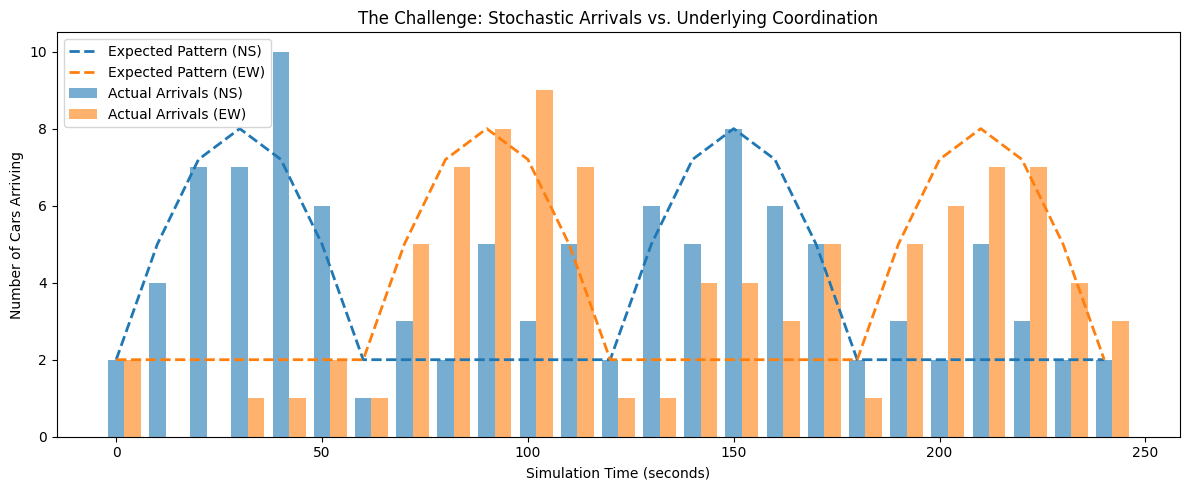

In [31]:
env = TrafficIntersectionEnv()
env.reset(seed=EVAL_SEED)

history = {
    "step": [],
    "ns_actual": [],
    "ew_actual": [],
    "ns_prob": [],
    "ew_prob": []
}

for step in range(25):
    _, _, _, _, info = env.step(Action.KEEP.value) 
    
    t = step * 10
    history["step"].append(t)
    
    history["ns_actual"].append(info['arrivals'][0] + info['arrivals'][2])
    history["ew_actual"].append(info['arrivals'][1] + info['arrivals'][3])
    
    history["ns_prob"].append(info['ns_rate'] * env.dt * 2) 
    history["ew_prob"].append(info['ew_rate'] * env.dt * 2)

plt.figure(figsize=(12, 5))

plt.plot(history["step"], history["ns_prob"], color='tab:blue', linestyle='--', linewidth=2, label="Expected Pattern (NS)")
plt.plot(history["step"], history["ew_prob"], color='tab:orange', linestyle='--', linewidth=2, label="Expected Pattern (EW)")

plt.bar(history["step"], history["ns_actual"], width=4, alpha=0.6, color='tab:blue', label="Actual Arrivals (NS)")
plt.bar(np.array(history["step"]) + 4, history["ew_actual"], width=4, alpha=0.6, color='tab:orange', label="Actual Arrivals (EW)")

plt.title("The Challenge: Stochastic Arrivals vs. Underlying Coordination")
plt.xlabel("Simulation Time (seconds)")
plt.ylabel("Number of Cars Arriving")
plt.legend(loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

## 3. Baseline Benchmarks

In this section, we establish performance benchmarks using traditional heuristics. These baselines provide a critical reference point for evaluating the effectiveness of our Reinforcement Learning agents.

**Evaluation Methodology**
To ensure a rigorous and fair comparison, all algorithms are evaluated under identical experimental conditions:
1.  **Reproducibility:** Each agent is evaluated over **10 independent runs**.
2.  **Controlled Environment:** We use a fixed set of random seeds for the environment. This guarantees that every agent faces the **exact same sequence** of vehicle arrivals, platoons, and stochastic delays.
3.  **Metric:** We primarily track the **Total Queue Length** over time to visualize stability and congestion relief.

### 3.1. Random Policy
The Random Policy selects an action $a_t \in \{0, 1\}$ uniformly at random at each timestep ($P(Keep) = P(Switch) = 0.5$).

**Analysis:**
As observed in the plot below, this strategy fails catastrophically. The queue length **diverges**, growing linearly and indefinitely. This result highlights the severity of the **Startup Lost Time** constraint. By switching phases too frequently (roughly every 20 seconds), the random agent throws away a significant amount of potential road capacity. The discharge rate drops below the arrival rate, and the system enters an unstable state from which it cannot recover.

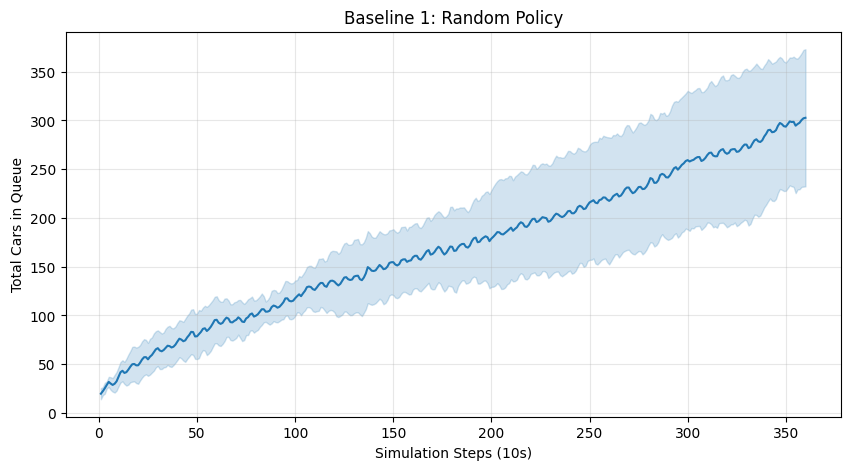

In [3]:
random_policy = RandomPolicy(TrafficIntersectionEnv(), seed=EVAL_SEED)

random_df = evaluate_policy(random_policy, TrafficIntersectionEnv(), n_runs=N_RUNS, start_seed=EVAL_SEED)

plot_average_episode(random_df, title="Baseline 1: Random Policy", color="tab:blue")

### 3.2. Greedy Policy
The Greedy Policy is a reactive heuristic: it always sets the green light to the direction with the longest queue. Specifically, if $Q_{red} > Q_{green}$, it switches immediately.

**Analysis of Failure:**
Contrary to intuition, the Pure Greedy strategy **performs poorly**, yielding results similar to the Random Policy.
* **The Cause:** The policy suffers from **"Flickering"**. As soon as the red queue exceeds the green queue by a single vehicle, the agent switches.
* **The Consequence:** This leads to rapid oscillations. The intersection spends excessive time in the "Startup Lost Time" state, destroying capacity.
* **Conclusion:** This baseline demonstrates that **reactive behaviour is insufficient**. A successful controller must plan ahead to batch traffic (platooning) rather than reacting to immediate imbalances.

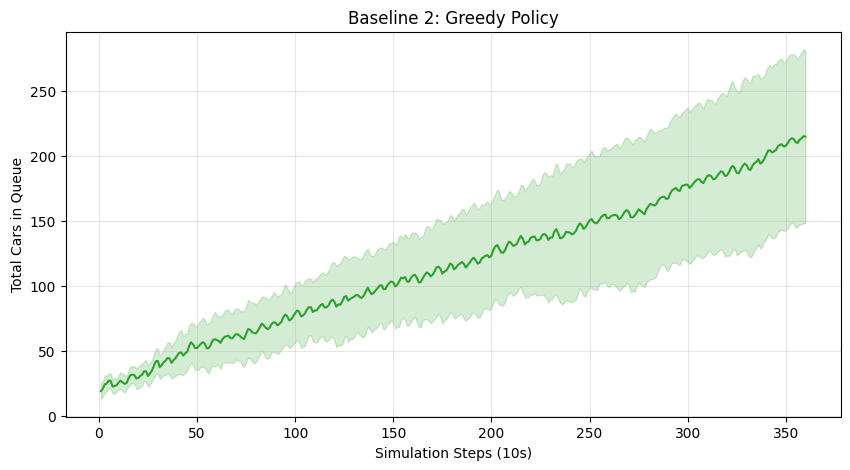

In [4]:
greedy_policy = GreedyPolicy(TrafficIntersectionEnv())

greedy_df = evaluate_policy(greedy_policy, TrafficIntersectionEnv(), n_runs=N_RUNS, start_seed=EVAL_SEED)

plot_average_episode(greedy_df, "Baseline 2: Greedy Policy", "tab:green")

### 3.3. Fixed Cycle Policy
The Fixed Cycle Policy operates on a pre-determined timer, switching phases every $N$ seconds.

**Optimization:**
We performed a hyperparameter sweep on the cycle length. As shown in the optimization plot, the **Optimal Cycle Length is 6 steps (60 seconds)**.

**Analysis:**
Unlike the other policies, the Fixed Cycle strategy is stable and performs significantly better, maintaining an average queue of $\approx 27$ cars.
* **The Reason:** Our environment simulates an urban grid where traffic arrives in coordinated platoons (due to upstream gating). The Fixed Cycle policy naturally aligns with this structure. By maintaining a steady rhythm, it allows whole platoons to pass through without interruption, minimizing the impact of startup lost time.
* **The Limitation:** While effective, it is **non-adaptive**. If the upstream timing shifts or traffic density changes, this static policy cannot adjust, potentially wasting green time on empty lanes.


Optimal Cycle Length: 6 steps (60s)


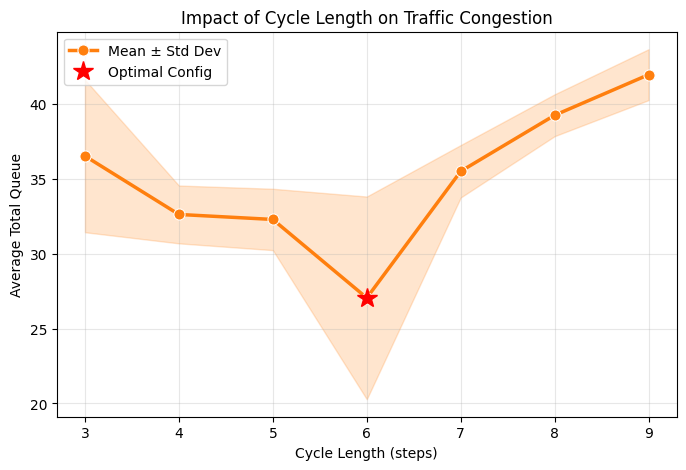

In [5]:
cycle_lengths = range(3, 10)
sweep_data = []

for c in cycle_lengths:
    agent = CyclePolicy(env, cycle_length=c)
    
    df = evaluate_policy(agent, env, n_runs=N_RUNS, start_seed=EVAL_SEED)
    
    run_averages = df.groupby("run")["cars_in_queue"].mean()
    
    for r, val in run_averages.items():
        sweep_data.append({
            "Cycle Length (Steps)": c,
            "Avg Queue": val
        })

df_sweep = pd.DataFrame(sweep_data)

global_means = df_sweep.groupby("Cycle Length (Steps)")["Avg Queue"].mean()
best_cycle_len = global_means.idxmin()
best_score = global_means.min()

print(f"\nOptimal Cycle Length: {best_cycle_len} steps ({best_cycle_len*10}s)")

plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_sweep, 
    x="Cycle Length (Steps)", 
    y="Avg Queue", 
    marker='o', 
    markersize=8,
    linewidth=2.5,
    color="tab:orange",
    errorbar='sd',
    label="Mean ± Std Dev"
)

plt.plot(best_cycle_len, best_score, 'r*', markersize=15, label="Optimal Config", zorder=5)

plt.title("Impact of Cycle Length on Traffic Congestion")
plt.xlabel("Cycle Length (steps)")
plt.ylabel("Average Total Queue")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left")
plt.show()

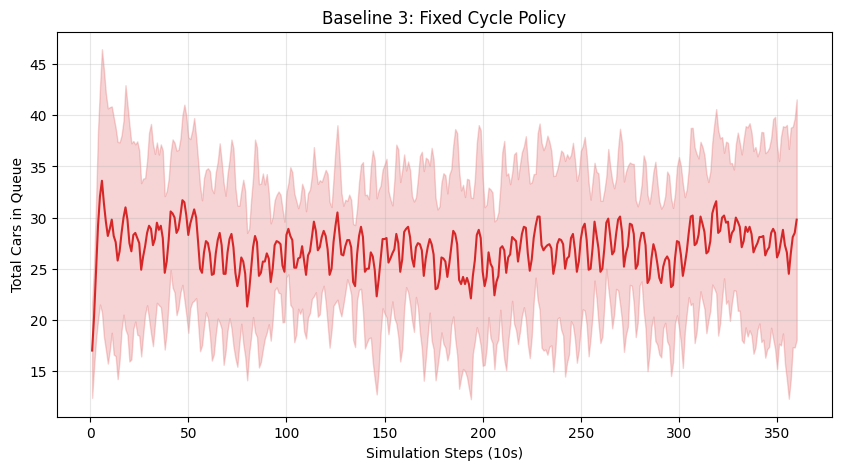

In [ ]:
cycle_policy = CyclePolicy(TrafficIntersectionEnv(), cycle_length=best_cycle_len)

cycle_df = evaluate_policy(cycle_policy, TrafficIntersectionEnv(), n_runs=N_RUNS, start_seed=EVAL_SEED)

cycle_mean = cycle_df["cars_in_queue"].mean()

plot_average_episode(cycle_df, title="Baseline 3: Fixed Cycle Policy", color="tab:red")

### 3.4. Baseline Summary & Conclusion

The combined plot below illustrates the performance hierarchy of our baselines. Note that error bands have been removed for clarity to highlight the trajectory trends.

**Key Observations:**
1.  **Instability of Reactivity:** Both **Random** and **Greedy** strategies fail. The Greedy heuristic, despite being "smart," gets trapped in a loop of rapid switching ("flickering") because it reacts to immediate queue differences rather than planning for incoming platoons. This leads to **system divergence**, where the queue grows indefinitely.
2.  **Stability of Structure:** The **Fixed Cycle** policy is the only baseline that achieves **stability**. Its success proves that in a coordinated environment, holding the light stable to clear platoons is far more important than reacting to every single vehicle.

**Conclusion:**
The **Fixed Cycle (60s)** represents the state-of-the-art (SOTA) baseline. To justify the complexity of Reinforcement Learning, our agents must demonstrate:
1.  **Stability:** They must avoid the divergent behavior of the Greedy heuristic.
2.  **Optimality:** They must achieve a lower average queue than the Fixed Cycle policy ($< 27$ cars) by adapting to stochastic variations that the static timer misses.

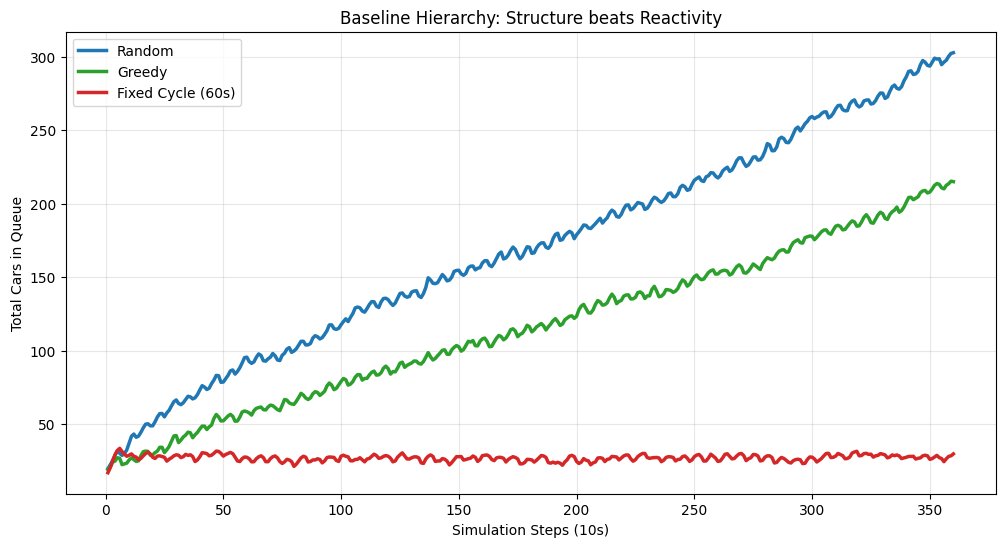

In [7]:
random_df["Algorithm"] = "Random"
greedy_df["Algorithm"] = "Greedy"
cycle_df["Algorithm"] = "Fixed Cycle (60s)"

all_baselines = pd.concat([random_df, greedy_df, cycle_df], ignore_index=True)

plt.figure(figsize=(12, 5))

sns.lineplot(
    data=all_baselines, 
    x="step", 
    y="cars_in_queue", 
    hue="Algorithm",
    linewidth=2.5,
    palette=["tab:blue", "tab:green", "tab:red"],
    errorbar=None 
)

plt.title("Baseline Hierarchy: Structure beats Reactivity")
plt.xlabel("Simulation Steps (10s)")
plt.ylabel("Total Cars in Queue")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 4. Reinforcement Learning Approaches

The baseline analysis highlighted a fundamental trade-off:
* **Fixed Cycle** offers **Stability** but lacks adaptability.
* **Greedy Heuristic** offers **Adaptability** but suffers from instability (flickering).

Reinforcement Learning (RL) theoretically solves this dilemma. By optimizing for the **Expected Cumulative Return** ($G_t = \sum \gamma^k R_{t+k+1}$) rather than immediate reward, an RL agent can learn to:
1.  **Plan Ahead:** Tolerate a small immediate queue to wait for a platoon (unlike Greedy).
2.  **Adapt:** Extend a green light dynamically if traffic is still flowing (unlike Fixed Cycle).

We evaluate two distinct RL paradigms: **Tabular Control** (SARSA) and **Function Approximation** (DQN).

### 4.1. Tabular SARSA($\lambda$)
Our first approach is **SARSA($\lambda$)** with Eligibility Traces.

**Challenges & Solutions:**
* **Dimensionality Reduction:** The raw environment provides 4 continuous queue lengths. To make Tabular Learning feasible, we employ an **Aggregation & Discretization Wrapper**.
    1.  **Aggregation:** We sum the queues for each signal phase (North+South, East+West) since the traffic light controls them simultaneously.
    2.  **Binning:** We discretize these aggregated totals into coarse bins (e.g., Low, Medium, High).
    * **Result:** This compresses the state space into a compact 4-dimensional vector $[Q_{NS}, Q_{EW}, Phase, Time]$, enabling faster convergence.

**Hyperparameter Tuning (The Bias-Variance Trade-off):**
The decay rate $\lambda$ is critical for convergence stability. We performed a full-spectrum sweep ($\lambda \in [0.0, ..., 1.0]$) over **50,000 training steps** to determine the optimal configuration.

**Analysis of Results:**
As shown in the sweep plot below, the optimal decay rate is **$\lambda=0.2$**.
* **High $\lambda$ (>0.8):** While traces speed up initial learning, they introduce significant variance due to the stochastic nature of vehicle arrivals. The agent over-reacts to "noisy" episodes, preventing stable convergence.
* **Low $\lambda$ (0.2):** By relying more heavily on bootstrapping (TD), the agent filters out the stochastic noise of individual platoons. Over the extended training horizon (50k steps), this stability allowed the tabular agent to fine-tune its policy and **surpass the Fixed Cycle baseline**.

Running SARSA Lambda Sweep (lambdas=[0.0, 0.2, 0.4, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])...


100%|██████████| 11/11 [14:08<00:00, 77.09s/it]

Optimal Lambda: 0.2


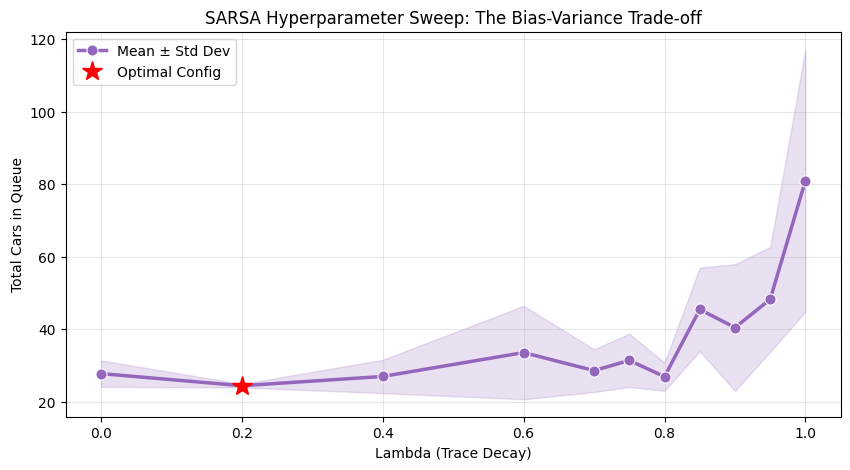

In [10]:
lambda_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

sweep_results = []

print(f"Running SARSA Lambda Sweep (lambdas={lambda_values})...")

for lam in tqdm(lambda_values):
    best_lambda_factory = lambda x: SarsaLambda(
        AggregateBinQueues(TrafficIntersectionEnv()), lambd=lam, seed=TRAIN_SEED + x
    )

    df = get_learning_curves(
        agent_factory=best_lambda_factory,
        eval_env=AggregateBinQueues(TrafficIntersectionEnv()),
        training_steps=TRAINING_STEPS,
        n_runs=5,
        eval_start_seed=EVAL_SEED,
    )

    cutoff_step = TRAINING_STEPS * 0.8
    final_performance_df = df[df["step"] >= cutoff_step]

    run_means = final_performance_df.groupby("run")["cars_in_queue"].mean()

    for r, val in run_means.items():
        sweep_results.append({"Lambda": lam, "cars_in_queue": val})

df_sweep_sarsa = pd.DataFrame(sweep_results)

best_lambda = df_sweep_sarsa.groupby("Lambda")["cars_in_queue"].mean().idxmin()
print(f"Optimal Lambda: {best_lambda}")

plt.figure(figsize=(10, 5))

sns.lineplot(
    data=df_sweep_sarsa,
    x="Lambda",
    y="cars_in_queue",
    marker="o",
    markersize=8,
    linewidth=2.5,
    color="tab:purple",
    errorbar="sd",
    label="Mean ± Std Dev",
)

best_val = df_sweep_sarsa.groupby("Lambda")["cars_in_queue"].mean().min()
plt.plot(best_lambda, best_val, "r*", markersize=15, label="Optimal Config", zorder=5)

plt.title("SARSA Hyperparameter Sweep: The Bias-Variance Trade-off")
plt.xlabel("Lambda (Trace Decay)")
plt.ylabel("Total Cars in Queue")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [18]:
best_lambda_factory = lambda x: SarsaLambda(
    AggregateBinQueues(TrafficIntersectionEnv()), lambd=best_lambda, seed=TRAIN_SEED + x
)

df_sarsa_best = get_learning_curves(
    agent_factory=best_lambda_factory,
    eval_env=AggregateBinQueues(TrafficIntersectionEnv()),
    training_steps=TRAINING_STEPS,
    n_runs=5,
    eval_start_seed=EVAL_SEED,
)

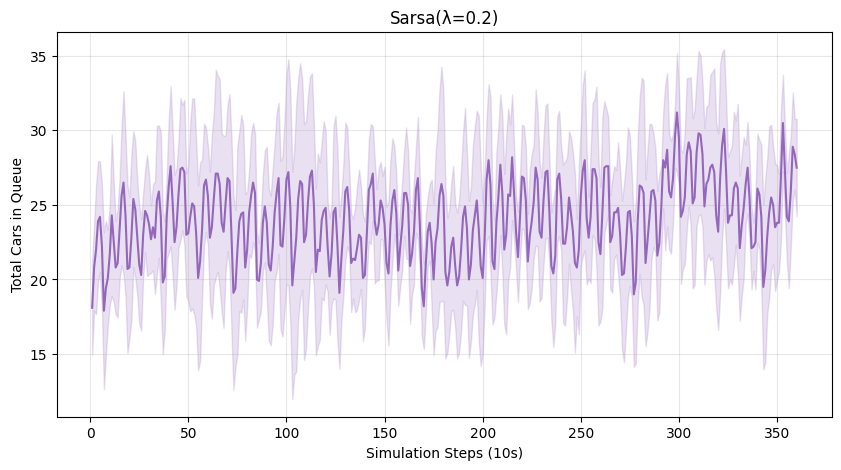

In [14]:
sarsa = SarsaLambda(AggregateBinQueues(TrafficIntersectionEnv()), lambd=best_lambda, seed=TRAIN_SEED)
sarsa.learn(timesteps=TRAINING_STEPS)

sarsa_df = evaluate_policy(sarsa, AggregateBinQueues(TrafficIntersectionEnv()), n_runs=N_RUNS, start_seed=EVAL_SEED)

plot_average_episode(sarsa_df, title=f"Sarsa(λ={best_lambda})", color="tab:purple")

### 4.2. Deep Q-Network (DQN)
While Tabular SARSA proved effective, it required **manual feature engineering** (aggregation and binning) to reduce the state space. A **Deep Q-Network (DQN)** removes this constraint by using a Neural Network to approximate the Q-values directly from the raw state.

**Advantages:**
1.  **Continuous State Perception:** The agent perceives exact queue lengths. This allows fine-grained control: the agent can distinguish between "20 cars" and "25 cars," whereas the tabular agent might lump both into a generic "High" bucket.
2.  **Generalization:** Knowledge learned from one state transfers to similar states. If the agent learns that switching is optimal at 20 cars, the neural network generalizes this to 21 cars, improving sample efficiency.

**Network Architecture:**
* **Input:** 6-dimensional normalized vector $[Q_N, Q_E, Q_S, Q_W, Phase, Time]$.
* **Network:** Multilayer Perceptron (MLP) with 2 hidden layers of 64 units (ReLU activation).
* **Stability:** We utilize a **Replay Buffer** to break temporal correlations and a **Target Network** to stabilize the Bellman updates.

Training DQN (10 runs)...


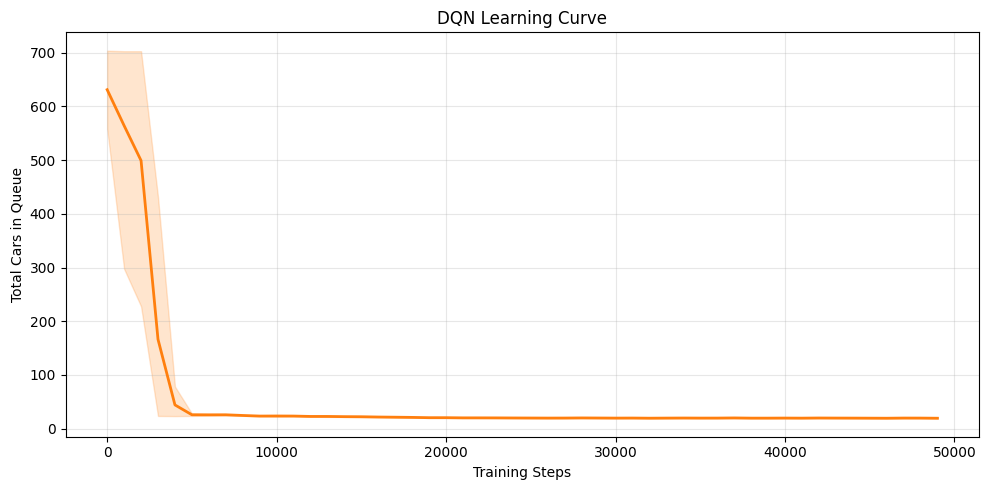

In [15]:
dqn_factory = lambda x: DQN(
    TrafficIntersectionEnv(),
    seed=TRAIN_SEED + x
)

df_dqn = get_learning_curves(
    agent_factory=dqn_factory,
    eval_env=TrafficIntersectionEnv(),
    training_steps=TRAINING_STEPS,
    n_runs=5,
    eval_start_seed=EVAL_SEED
)

plt.figure(figsize=(10, 5))

sns.lineplot(
    data=df_dqn,
    x="step",
    y="cars_in_queue",
    color="tab:orange",
    linewidth=2
)

plt.title("DQN Learning Curve")
plt.xlabel("Training Steps")
plt.ylabel("Total Cars in Queue")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

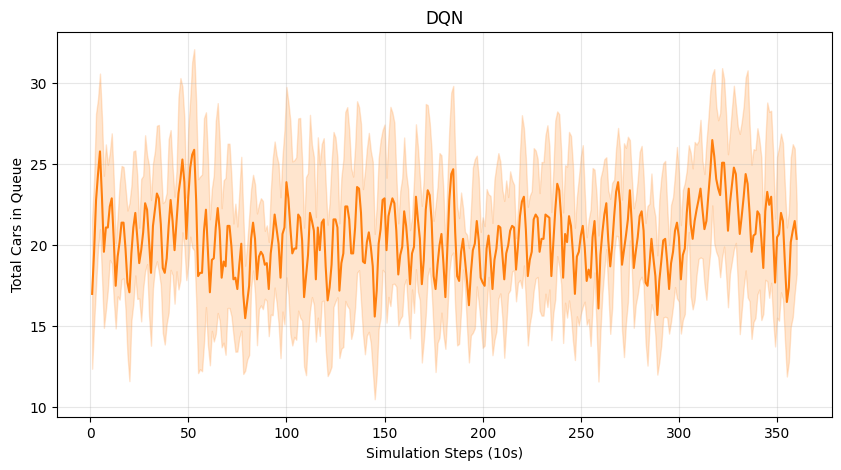

In [16]:
dqn = DQN(TrafficIntersectionEnv(), seed=TRAIN_SEED)
dqn.learn(timesteps=TRAINING_STEPS)

dqn_df = evaluate_policy(dqn, TrafficIntersectionEnv(), n_runs=N_RUNS, start_seed=EVAL_SEED)

plot_average_episode(dqn_df, title="DQN", color="tab:orange")

## 5. Comparative Analysis: Deep vs. Tabular vs. SOTA Baseline

We now bring our results together to answer the core research question: **Can Reinforcement Learning outperform optimized static traffic control?**

In this final comparison, we exclude the Greedy and Random policies as they were proven unstable. Instead, we focus strictly on the **State-of-the-Art (SOTA) Baseline**: the Optimized Fixed Cycle (60s).

We compare:
1.  **Fixed Cycle (Baseline):** The stable, optimized static timer (Cycle=6).
2.  **SARSA($\lambda=0.2$):** The best performing Tabular agent (selected from the sweep).
3.  **DQN:** The Deep Learning agent with continuous state perception.

The plot below illustrates the **Learning Efficiency**—comparing not just the final performance, but how much experience (timesteps) each agent needed to discover a superior policy.

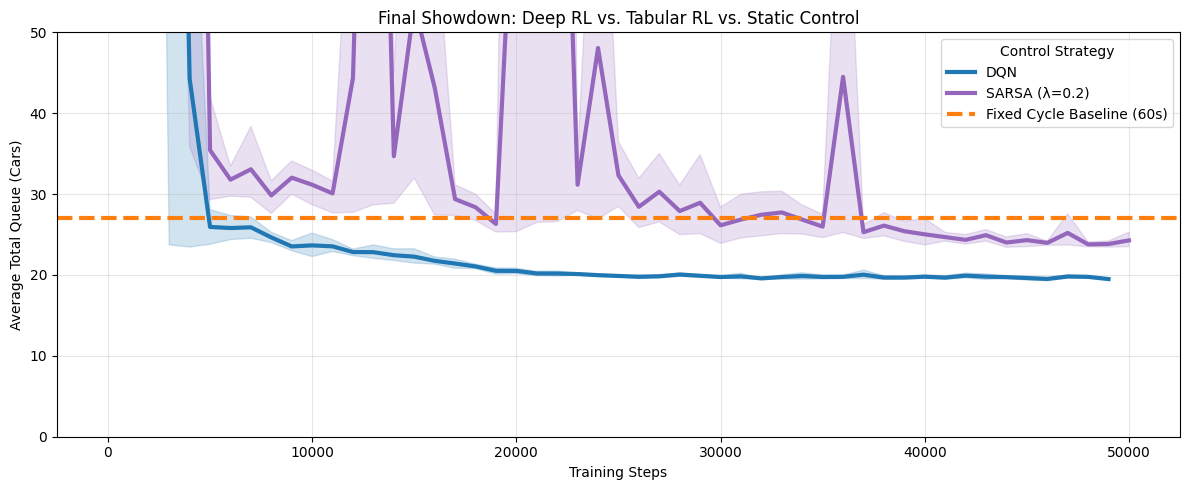

In [35]:
df_sarsa_best["Algorithm"] = f"SARSA (λ={best_lambda})"
df_dqn["Algorithm"] = "DQN"

final_comparison = pd.concat([df_dqn, df_sarsa_best], ignore_index=True)

plt.figure(figsize=(12, 5))

sns.lineplot(
    data=final_comparison,
    x="step",
    y="cars_in_queue", 
    hue="Algorithm",
    linewidth=3, 
    palette=["tab:blue", "tab:purple"] 
)

plt.axhline(cycle_mean, color='tab:orange', linestyle='--', linewidth=3, label=f"Fixed Cycle Baseline ({best_cycle_len*10}s)")

plt.ylim(0, 50)

plt.title("Final Showdown: Deep RL vs. Tabular RL vs. Static Control")
plt.xlabel("Training Steps")
plt.ylabel("Average Total Queue (Cars)")
plt.legend(title="Control Strategy", loc="upper right", frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.1. Discussion of Results

The comparative analysis reveals distinct performance characteristics for each control strategy:

**1. Convergence of Tabular Methods:**
**SARSA($\lambda$)** successfully validates the efficacy of adaptive control, outperforming the Fixed Cycle baseline.
* **Sample Efficiency:** The primary limitation is sample efficiency. The agent required approximately **35,000 steps** to converge.
* **State Representation:** The reliance on discretized state buckets introduces a precision bottleneck. While effective for stability, the coarse granulation prevents the agent from achieving the theoretical optimum, as it cannot differentiate between minor queue variations near the bucket boundaries.

**2. Efficacy of Function Approximation (DQN):**
**DQN** demonstrates superior performance metrics across all categories.
* **Convergence Speed:** The network converged to a stable policy in under **5,000 steps**, exhibiting significantly higher sample efficiency than the tabular approach.
* **Optimality:** The final average queue of $\approx 20$ cars represents a **~25% reduction** compared to the optimized Fixed Cycle.
* **Mechanism:** The continuous state representation allows the policy to leverage exact queue lengths. The Neural Network's ability to generalize experience across similar states (e.g., 20 cars $\approx$ 21 cars) accelerates learning and enables fine-grained control adjustments that discretized methods miss.

## 6. Conclusion

This project developed a realistic, non-stationary traffic control environment to benchmark Reinforcement Learning algorithms against traditional traffic engineering heuristics.

**Key Findings:**
1.  **Limitations of Reactive Heuristics:** Purely reactive strategies, such as the **Greedy Policy**, failed to stabilize the intersection. The high switching frequency ("flickering") induced by minor queue imbalances resulted in severe capacity loss due to startup delays.
2.  **Robustness of Static Control:** The **Fixed Cycle** policy provided a stable baseline, preventing divergence by enforcing a structured discharge rhythm. However, its inability to adapt to stochastic fluctuations resulted in suboptimal queuing.
3.  **Superiority of Deep RL:** By combining the stability of planning (via Q-learning) with the precision of function approximation, **DQN** outperformed the state-of-the-art static controller by **~25%**, validating its potential for real-world adaptive signal control.

**Future Work:**
To extend this research toward deployment, future iterations will focus on:
* **Multi-Agent RL (MARL):** Scaling to a grid of connected intersections to optimize for city-wide "Green Waves."
* **Visual Perception:** Integrating Convolutional Neural Networks (CNNs) to estimate queue lengths directly from camera feeds, removing the reliance on perfect numerical sensors.
* **High-Fidelity Simulation:** Porting the trained agents to industry-standard simulators (e.g., SUMO, CityFlow) to validate performance under complex car-following models and lane-changing dynamics.